# Homework 2

## FINM 36700 - 2023

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

## HBS Case

### *The Harvard Management Company and Inflation-Indexed Bonds*

***

# 1. The ProShares ETF Product

**Section 1 is not graded**, and you do not need to submit your answers. But you are encouraged to think about them, and we will discuss them.

## 1. Alternative ETFs

Describe the two types of investments referenced by this term.

## 2. Hedge Funds.

#### a. Using just the information in the case, what are two measures by which hedge funds are an attractive investment?

#### b. What are the main benefits of investing in hedge funds via an ETF instead of directly?

## 3. The Benchmarks

#### a. Explain as simply as possible how HFRI, MLFM, MLFM-ES, and HDG differ in their construction and purpose.

#### b. How well does the Merrill Lynch Factor Model (MLFM) track the HFRI?

#### c. In which factor does the MLFM have the largest loading? (See a slide in Exhibit 1.)

#### d. What are the main concerns you have for how the MLFM attempts to replicate the HFRI?

## 4. The HDG Product

#### a. What does ProShares ETF, HDG, attempt to track? Is the tracking error small?

#### b. HDG is, by construction, delivering beta for investors. Isn't the point of hedge funds to generate alpha? Then why would HDG be valuable?

#### c. The fees of a typical hedge-fund are 2% on total assets plus 20% of excess returns if positive. HDG's expense ratio is roughly 1% on total assets. What would their respective net Sharpe Ratios be, assuming both have a gross excess returns of 10% and volatility of 20%?

***

# 2.  Analyzing the Data

Use the data found on Canvas, in <b>'proshares analysis data.xlsx'</b>. 

It has monthly data on financial indexes and ETFs from `Aug 2011` through `Aug 2023`.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

import matplotlib.pyplot as plt

## 1. 

For the series in the "hedge fund series" tab, report the following summary statistics:
* mean
* volatility
* Sharpe ratio

Annualize these statistics.

In [2]:
def return_statistics(asset_return):
    
    df = pd.DataFrame({
    'Annualized_Return': asset_return.mean() * 12,
    'Annualized_Volatility': asset_return.std() * np.sqrt(12),
    'Annualized_Sharp_Ratio': (asset_return.mean() * 12) / (asset_return.std() * np.sqrt(12))})\
    .astype({'Annualized_Return': 'float', 'Annualized_Volatility': 'float', 'Annualized_Sharp_Ratio': 'float'})\
    [['Annualized_Return', 'Annualized_Volatility', 'Annualized_Sharp_Ratio']]
    
    return df

In [92]:
data_hf = pd.read_excel('proshares_analysis_data.xlsx', sheet_name = 1, index_col = 'Unnamed: 0')
data_merrill = pd.read_excel('proshares_analysis_data.xlsx', sheet_name = 2, index_col = 'Unnamed: 0')
data_hf.index.name = 'Date'
data_merrill.index.name = 'Date'
#data_hf = data_hf.merge(data_merrill.loc[:,['SPY US Equity']], left_index = True, right_index = True)
data_hf

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
Date,,,,,
2011-08-31,-0.032149,-0.025588,-0.025689,-0.027034,-0.006491
2011-09-30,-0.038903,-0.032414,-0.032593,-0.032466,-0.022143
2011-10-31,0.026858,0.043593,0.043320,0.050532,0.025242
2011-11-30,-0.013453,-0.012142,-0.012431,-0.028607,-0.007963
2011-12-31,-0.004479,0.001938,0.001796,0.012874,0.001818
...,...,...,...,...,...
2023-04-30,0.002400,0.000852,0.000333,-0.000440,0.005135
2023-05-31,-0.002000,-0.001045,-0.001458,-0.001446,-0.006471
2023-06-30,0.021400,0.015901,0.015936,0.016662,0.022626


In [93]:
result_stats = return_statistics(data_hf)
result_stats

,Annualized_Return,Annualized_Volatility,Annualized_Sharp_Ratio
HFRIFWI Index,0.043223,0.060228,0.717668
MLEIFCTR Index,0.031885,0.056966,0.559721
MLEIFCTX Index,0.030399,0.056806,0.535142
HDG US Equity,0.020513,0.059367,0.345534
QAI US Equity,0.019611,0.050062,0.391729


## 2.

For the series in the "hedge fund series" tab, calculate the following statistics related to tail-risk.
* Skewness
* Excess Kurtosis (in excess of 3)
* VaR (.05) - the fifth quantile of historic returns
* CVaR (.05) - the mean of the returns at or below the fifth quantile
* Maximum drawdown - include the dates of the max/min/recovery within the max drawdown period.

There is no need to annualize any of these statistics.

In [94]:
def performance_summary(return_data):

    summary_stats = return_data.skew().to_frame('Skewness')
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (.05)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (.05)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    
    wealth_index = 1000 * (1 + return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

In [95]:
statistics = performance_summary(data_hf)
statistics

,Skewness,Excess Kurtosis,VaR (.05),CVaR (.05),Max Drawdown,Peak,Bottom,Recovery
HFRIFWI Index,-0.983171,5.918307,-0.025130,-0.037478,-0.115473,2019-12-31,2020-03-31,2020-08-31
MLEIFCTR Index,-0.255827,1.664342,-0.028656,-0.035857,-0.124302,2021-06-30,2022-09-30,NaT
MLEIFCTX Index,-0.241814,1.631565,-0.028927,-0.035816,-0.124388,2021-06-30,2022-09-30,NaT
HDG US Equity,-0.243959,1.780069,-0.031158,-0.037576,-0.140721,2021-06-30,2022-09-30,NaT
QAI US Equity,-0.458360,1.737586,-0.020086,-0.032696,-0.137716,2021-06-30,2022-09-30,NaT


## 3. 

For the series in the "hedge fund series" tab, run a regression of each against SPY (found in the "merrill factors" tab.) Include an intercept. Report the following regression-based statistics:
* Market Beta
* Treynor Ratio
* Information ratio

Annualize these three statistics as appropriate.

In [110]:
def performance_statistics(hedge_funds, SPY, rf):
    
    results = pd.DataFrame(data = None, 
                columns = ['Market Beta', 'Treynor Ratio', 'Information ratio', 'RSquared', 'Alpha'])

    
    for fund in hedge_funds.columns:
        
        
        X = sm.tools.add_constant(SPY)
        y = hedge_funds[fund] 
        model = sm.OLS(y, X, missing='drop').fit()
        alpha = model.params[:1].values[0]
        beta = model.params[1:].values[0]
        treynor_ratio = 12 * (y - rf).mean() / beta
        tracking_error = model.resid.std() * np.sqrt(12)
        information_ratio = alpha * 12 / tracking_error
        r_squared = model.rsquared
        results.loc[fund, 'Market Beta'] = beta
        results.loc[fund, 'Treynor Ratio'] = treynor_ratio
        results.loc[fund, 'Information ratio'] = information_ratio
        results.loc[fund, 'RSquared'] = r_squared
        results.loc[fund, 'Alpha'] = alpha
        
    return results

In [111]:
res = performance_statistics(data_hf, data_merrill['SPY US Equity'], data_merrill['USGG3M Index'])
res

,Market Beta,Treynor Ratio,Information ratio,RSquared,Alpha
HFRIFWI Index,0.348706,0.097045,-0.100529,0.714001,-0.00027
MLEIFCTR Index,0.34962,0.06436,-0.580287,0.802298,-0.001225
MLEIFCTX Index,0.348325,0.060334,-0.631588,0.800846,-0.001334
HDG US Equity,0.359366,0.030971,-0.983914,0.780469,-0.002281
QAI US Equity,0.296053,0.034546,-0.784446,0.74489,-0.001653


## 4. 

Discuss the previous statistics, and what they tell us about...

* the differences between SPY and the hedge-fund series?
* which performs better between HDG and QAI.
* whether HDG and the ML series capture the most notable properties of HFRI.

### The differences between SPY and the hedge-fund series:

In [112]:
statistics = performance_summary(pd.concat([data_hf, data_merrill['SPY US Equity']], axis = 1))
statistics

,Skewness,Excess Kurtosis,VaR (.05),CVaR (.05),Max Drawdown,Peak,Bottom,Recovery
HFRIFWI Index,-0.983171,5.918307,-0.025130,-0.037478,-0.115473,2019-12-31,2020-03-31,2020-08-31
MLEIFCTR Index,-0.255827,1.664342,-0.028656,-0.035857,-0.124302,2021-06-30,2022-09-30,NaT
MLEIFCTX Index,-0.241814,1.631565,-0.028927,-0.035816,-0.124388,2021-06-30,2022-09-30,NaT
HDG US Equity,-0.243959,1.780069,-0.031158,-0.037576,-0.140721,2021-06-30,2022-09-30,NaT
QAI US Equity,-0.458360,1.737586,-0.020086,-0.032696,-0.137716,2021-06-30,2022-09-30,NaT
SPY US Equity,-0.411185,0.788528,-0.068038,-0.086661,-0.239271,2021-12-31,2022-09-30,NaT


**Statistics related to tail risks**:

1. Compared to SPY US Equity, all hedge funds have considerably higher Excess Kurtosis, which indicates heavy tails on the bell-shaped distribution curve, so the higher tail risk. 

2. The above conclusion about tail risk is proved by VaR and CVar: SPY has lower tail risk than any other hedge fund.

3. Among all Hedge Funds Indexes and SPY, only HFRIFWI Index was able to recovery from drawdown

In [114]:
res = performance_statistics(pd.concat([data_hf, data_merrill['SPY US Equity']],axis = 1), data_merrill['SPY US Equity'],
                             data_merrill['USGG3M Index'])
res

,Market Beta,Treynor Ratio,Information ratio,RSquared,Alpha
HFRIFWI Index,0.348706,0.097045,-0.100529,0.714001,-0.00027
MLEIFCTR Index,0.34962,0.06436,-0.580287,0.802298,-0.001225
MLEIFCTX Index,0.348325,0.060334,-0.631588,0.800846,-0.001334
HDG US Equity,0.359366,0.030971,-0.983914,0.780469,-0.002281
QAI US Equity,0.296053,0.034546,-0.784446,0.74489,-0.001653
SPY US Equity,1.0,0.123856,-4.879831,1.0,-0.0


**Statistics based on Regression**:

1. All hedge funds are less volatile than SPY, because Market beta is less than 1. This is a result of asset diversification.

2. SPY has the largest Treynor Ratio among all hedge funds, so no hedge fund was able to surpass the market in terms of risk adjusted returns. 

3. All hedge funds have negative Information. It means that they fail to beat the market.

### Which performs better between HDG and QAI:

**Market beta**: HDG US Equity has a higher market beta than QAI US Equity, so HDG US Equity is more volotile compared to QAI US Equity. As a confirmation, we additionally calculated RSquared, which shows that high portion of variance is explained by the regression. 

**Treynor Ratio**: HDG US Equity has a smaller TR than QAI US Equity. That means QAI US Equity has higher risk adjusted returns. The result is expected, because:
$$
TR = \frac{\mathbb{E}(\tilde{r})}{\beta}
$$
So the higher market beta is, the lower risk adjusted returns are.

**Information Ratio**: because of negative Alpha, both HDG US Equity and QAI US Equity has negative IR. But since QAI has a less negative alpha, QAI has a better Information Ratio.

As a result, QAI shows better risk-adjusted returns

### Whether HDG and the ML series capture the most notable properties of HFRI.

1. Both HDG and the ML series show almost same market betas, which means that they have almost same market risks as HFRI.

2. However, HFRI has sufficiently higher Treynor Ratio than HDG and the ML series, which represents that they underperformed in terms of risk adjusted returns compared to HFRI

3. HDG and the ML series underperforms in terms of Information Ratio, which indicates returns unexplained by the market.

As a result, HDG, MLEIFCTR, MLEIFCTX do not capture the most notable properties of HFRI.

## 5. 

Report the correlation matrix for these assets.
* Show the correlations as a heat map.
* Which series have the highest and lowest correlations?

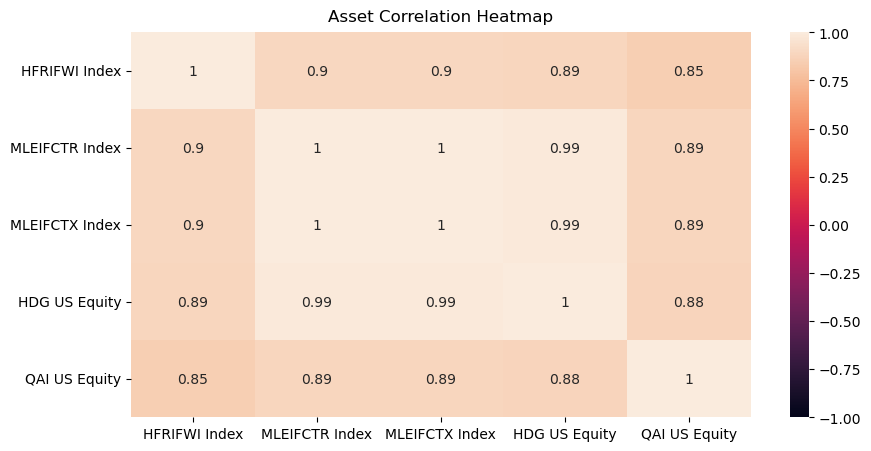

In [91]:
asset_corr = data_hf.corr()
plt.figure(figsize = (10,5))
heatmap = sns.heatmap(asset_corr, vmin = -1, vmax = 1, annot = True)
heatmap.set_title('Asset Correlation Heatmap', fontdict={'fontsize': 12}, pad = 8);

In [90]:
sorted_corr = asset_corr.unstack().sort_values().to_frame('Correlations')
sorted_corr = sorted_corr[sorted_corr['Correlations'] != 1]

max_corr = sorted_corr.nlargest(1, 'Correlations')
min_corr = sorted_corr.nsmallest(1, 'Correlations')
pd.concat([max_corr, min_corr])

,,Correlations
MLEIFCTX Index,MLEIFCTR Index,0.999921
HFRIFWI Index,SPY US Equity,0.844986


## 6.

Replicate HFRI with the six factors listed on the "merrill factors" tab. Include a constant, and run the unrestricted regression,

$\newcommand{\hfri}{\text{hfri}}$
$\newcommand{\merr}{\text{merr}}$

$$\begin{align}
r^{\hfri}_{t} &= \alpha^{\merr} + x_{t}^{\merr}\beta^{\merr} + \epsilon_{t}^{\merr}\\[5pt]
\hat{r}^{\hfri}_{t} &= \hat{\alpha}^{\merr} + x_{t}^{\merr}\hat{\beta}^{\merr}
\end{align}$$

Note that the second equation is just our notation for the fitted replication.

#### a. Report the intercept and betas.
#### b. Are the betas realistic position sizes, or do they require huge long-short positions?
#### c. Report the R-squared.
#### d. Report the volatility of $\epsilon^{\merr}$, the tracking error.

In [115]:
def replication_HFRI(HFRI, merrill_factors, constant):
    
    X = sm.tools.add_constant(merrill_factors)

    y = HFRI
    model = sm.OLS(y, X, missing='drop').fit()
    r_squared = model.rsquared
    sigma_merr = model.resid.std() * np.sqrt(12) 

    replication_stats = {'SPY US Equity': model.params[1], 'USGG3M Index': model.params[2],
                         'EEM US Equity': model.params[3], 'EFA US Equity': model.params[4], 
                         'EUO US Equity': model.params[5], 'IWM US Equity': model.params[6],
                         'Intercept': model.params[0], 'RSquared': r_squared, 'TrackingError': sigma_merr}
    data = pd.DataFrame(replication_stats, index = ['HFRIFWI Index'])
    
    return data

In [117]:
repl = replication_HFRI(data_hf['HFRIFWI Index'], data_merrill, constant = True)
repl

,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity,Intercept,RSquared,TrackingError
HFRIFWI Index,0.033308,-0.165908,0.077857,0.08241,0.022649,0.152074,0.001383,0.836901,0.024323


### Are the betas realistic position sizes, or do they require huge long-short positions?

In general, all the betas take realistic values. There is one relatively big short in USGG3M Index and one relatively big long in IWM US Equity.

# Maybe additional conclusions why it is so? I think these are good betas tho

## 7.

Let's examine the replication out-of-sample (OOS).

Starting with $t = 61$ month of the sample, do the following:

* Use the previous 60 months of data to estimate the regression equation. 
This gives time-t estimates of the regression parameters, $\tilde{\alpha}^{\merr}_{t}$ and $\tilde{\beta}^{\merr}_{t}$.

* Use the estimated regression parameters, along with the time-t regressor values, $x^{\merr}_{t}$, calculate the time-t replication value that is, with respect to the regression estimate, built "out-of-sample" (OOS).

$$\hat{r}^{\hfri}_{t} \equiv \tilde{\alpha}^{\merr} + (x_{t}^{\merr})'\tilde{\beta}^{\merr}$$

* Step forward to $t = 62$, and now use $t = 2$ through $t = 61$ for the estimation. Re-run the steps above, and continue this process throughout the data series. Thus, we are running a rolling, 60-month regression for each point-in-time.

How well does the out-of-sample replication perform with respect to the target?

In [145]:
original = data_hf[['HFRIFWI Index']].loc['2016-08-31':]

X = sm.add_constant(data_merrill)
y = data_hf['HFRIFWI Index']
rols = RollingOLS(y, X, window = 60).fit()

params = rols.params.copy()
factor_ret = data_merrill.loc['2016-08-31':]

one_df = pd.DataFrame(np.ones(factor_ret.shape[0]))
one_df.index = factor_ret.index
factor_ret = one_df.join(factor_ret, how='inner')
replicated_matrix = np.diag((np.array(params.iloc[60:]) @ np.array(factor_ret).T))

replicated = pd.DataFrame(replicated_matrix, index = data_hf.iloc[60:].index, columns = ['Replicated'])
df = pd.concat([original, replicated], axis = 1)

**Statistics for OOS replication**:

In [143]:
return_statistics(replicated)

,Annualized_Return,Annualized_Volatility,Annualized_Sharp_Ratio
Replicated,0.038736,0.061107,0.633911


In [149]:
performance_summary(replicated)

,Skewness,Excess Kurtosis,VaR (.05),CVaR (.05),Max Drawdown,Peak,Bottom,Recovery
Replicated,-0.667995,2.62196,-0.026953,-0.037413,-0.096517,2019-12-31,2020-03-31,2020-08-31


**Statistics original portfolio**:

In [144]:
return_statistics(original)

,Annualized_Return,Annualized_Volatility,Annualized_Sharp_Ratio
HFRIFWI Index,0.053975,0.06694,0.806316


In [151]:
performance_summary(original)

,Skewness,Excess Kurtosis,VaR (.05),CVaR (.05),Max Drawdown,Peak,Bottom,Recovery
HFRIFWI Index,-1.115531,6.678988,-0.02384,-0.040163,-0.115473,2019-12-31,2020-03-31,2020-08-31


In [147]:
df.corr()

,HFRIFWI Index,Replicated
HFRIFWI Index,1.000000,0.938882
Replicated,0.938882,1.000000


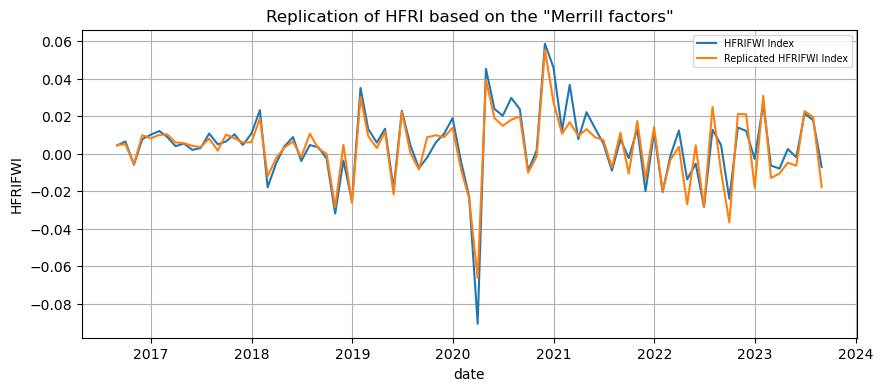

In [16]:
plt.figure(figsize=(10, 4))
plt.plot(data_hf['HFRIFWI Index'].loc['2016-08-31':], label='HFRIFWI Index')
plt.plot(replicated, label='Replicated HFRIFWI Index')
plt.title('Replication of HFRI based on the "Merrill factors"')
plt.xlabel('date')
plt.ylabel('HFRIFWI')
plt.grid(visible=1)
plt.legend(fontsize = 'x-small');

### Conclusion:

1. The graph illustrates that dynamics of both original and replicated index are close to each other. 

2. This result is confirmed by high positive correlation coefficient: 0.938

3. The fitted returns have lower annualized returns than original HFRI index. Even though the replicated returns have lower volatility than original HFRI index, the annualized Sharpe Ratio is larger for the original HFRI returns.

4. Another big diffirence is in Excess Kurtosis: the replicated returns have much lower Excess Kurtosis than the original returns

## 8.

We estimated the replications using an intercept. Try the full-sample estimation, but this time without an intercept.

$$\begin{align}
r^{\hfri}_{t} &= \alpha^{merr} + x_{t}^{\merr}\beta^{\merr} + \epsilon_{t}^{\merr}\\[5pt]
\check{r}^{\hfri}_{t} &= \check{\alpha}^{\merr} + x_{t}^{\merr}\check{\beta}^{\merr}
\end{align}$$

Report

* the regression beta. How does it compare to the estimated beta with an intercept, $\hat{\beta}^{\merr}$?

* the mean of the fitted value, $\check{r}^{\hfri}_{t}$. How does it compare to the mean of the HFRI?

* the correlations of the fitted values, $\check{r}^{\hfri}_{t}$ to the HFRI. How does the correlation compare to that of the fitted values with an intercept, $\hat{r}^{\hfri}_{t}$

Do you think Merrill and ProShares fit their replicators with an intercept or not?

In [17]:
def replication_HFRI_without_constant(HFRI, merrill_factors):
    
    X = merrill_factors
    y = HFRI
    model = sm.OLS(y, X, missing='drop').fit()
    r_squared = model.rsquared
    sigma_merr = model.resid.std() * np.sqrt(12) 

    replication_stats = {'SPY US Equity': model.params[0], 'USGG3M Index': model.params[1],
                         'EEM US Equity': model.params[2], 'EFA US Equity': model.params[3], 
                         'EUO US Equity': model.params[4], 'IWM US Equity': model.params[5],
                         'RSquared': r_squared, 'TrackingError': sigma_merr}
    data = pd.DataFrame(replication_stats, index = ['HFRIFWI Index'])
    
    return data

In [18]:
repl_with = replication_HFRI_without_constant(data_hf['HFRIFWI Index'], data_merrill)
repl_with

,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity,RSquared,TrackingError
HFRIFWI Index,0.050858,0.337787,0.077639,0.075253,0.025636,0.148556,0.839926,0.024436


In [19]:
repl_without = replication_HFRI(data_hf['HFRIFWI Index'], data_merrill, constant = True)
repl_without

,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity,Intercept,RSquared,TrackingError
HFRIFWI Index,0.033308,-0.165908,0.077857,0.08241,0.022649,0.152074,0.001383,0.836901,0.024323


In [20]:
# calculate 2, 3

The main goal of Merrill and ProShares was to replicate the HFRIFWI Index, that is to find a linear combination of factors, such as SPY US Equity, USGG3M Index, EEM US Equity, EFA US Equity, EUO US Equity, and IWM US Equity. 

Since $\alpha$ measures the excess return beyond what is explained by the factors, Merrill does not want to include it in the regression, because ...

***

# 3.  Extensions
<i>This section is not graded, and you do not need to submit it. Still, we may discuss it in class, in which case, you would be expected to know it.

## 1. 

Merrill constrains the weights of each asset in its replication regression of HFRI. Try constraining your weights by re-doing 2.6.

* Use Non-Negative Least Squares (NNLS) instead of OLS.
* Go further by using a Generalized Linear Model to put separate interval constraints on each beta, rather than simply constraining them to be non-negative.

#### Hints
* Try using LinearRegression in scikit-learn with the parameter `positive=True`. 
* Try using GLM in statsmodels.

## 2. 

Let's decompose a few other targets to see if they behave as their name suggests.

* Regress HEFA on the same style factors used to decompose HFRI. Does HEFA appear to be a currency-hedged version of EFA?

* Decompose TRVCI with the same style factors used to decompose HFRI. The TRVCI Index tracks venture capital funds--in terms of our styles, what best describes venture capital?

* TAIL is an ETF that tracks SPY, but that also buys put options to protect against market downturns. Calculate the statistics in questions 2.1-2.3 for TAIL. Does it seem to behave as indicated by this description? That is, does it have high correlation to SPY while delivering lower tail risk?

## 3. 

The ProShares case introduces Levered ETFs. ProShares made much of its name originally through levered, or "geared" ETFs.

Explain conceptually why Levered ETFs may track their index well for a given day but diverge over time. How is this exacerbated in volatile periods like 2008?

## 4.

Analyze SPXU and UPRO relative to SPY.
- SPXU is ProShares -3x SPX ETF.
- UPRO is ProShres +3x SPX ETF.

Questions:
* Analyze them with the statistics from 2.1-2.3. 

* Do these two ETFs seem to live up to their names?

* Plot the cumulative returns of both these ETFs along with SPY.

* What do you conclude about levered ETFs?

***